# Initialization

We must run some initialization code to import plotting lib and other helper methods 

In [2]:
%matplotlib widget

%load_ext autoreload
%autoreload 1

from pathlib import Path
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import qgrid

%aimport vis

pd.plotting.register_matplotlib_converters()
# wait until https://github.com/quantopian/qgrid/issues/261 is merged
# qgrid.enable()

# make sure we have log dir
while not Path('log').is_dir():
    %cd ..


def fuzzy_slug(slug):
    '''Given a slug, find a log_dir'''
    base_dir = Path('log')
    log_dir = base_dir / slug
    if not log_dir.is_dir():
        # try prefix match
        candidates = [p for p in base_dir.glob(f'{slug}*') if p.is_dir()]
        if len(candidates) == 1:
            log_dir = candidates[0]
            print(f'Using existing log_dir: {log_dir.name}')
            return log_dir
        elif len(candidates) > 1:
            raise ValueError(f'Multiple matches, use more specific name: {candidates}')
    raise ValueError(f'Log dir {log_dir} does not exist')

def load_jobs(slug, tag=''):
    # find log dir
    base_dir = Path('log')
    log_dir = base_dir / slug
    if not log_dir.is_dir():
        # try match
        for log_dir in base_dir.glob(f'*{slug}*'):
            if log_dir.is_dir():
                break
            raise ValueError(f'Log dir {log_dir} does not exist')
    
    # find file
    if tag:
        tag = tag + '-'
    csv_file = log_dir / f'{tag}jobs.csv'
    if not csv_file.is_file():
        # try glob
        for csv_file in log_dir.glob(f'*{tag}*jobs.csv'):
            if csv_file.is_file():
                break
            raise ValueError(f'CSV file {csv_file} does not exist')
    
    # load it
    print(f'Loading {csv_file}')
    total = pd.read_csv(str(csv_file))
    for col in ['StartTime', 'EndTime']:
        total[col] = pd.to_datetime(total[col])
    for col in ['Budget', 'Iter', 'Rung', 'JobId', 'Epoches', 'Node']:
        total[col] = pd.to_numeric(total[col])
    total['Duration'] = (total.EndTime - total.StartTime).astype('timedelta64[s]')
    return total

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Auto-PyTorch runs

### Two runs of Auto-PyTorch with 20 budgets and 2 iterations

In [3]:
df = pd.read_csv('log/2019-09-22T20:35:20/jobs.csv')
# df = pd.read_csv('log/2019-09-23T10:57:58/jobs.csv', sep='\t')
df['StartTime'] = pd.to_datetime(df['Start Time'])
df['EndTime'] = pd.to_datetime(df['End Time'])
df['Duration'] = df.EndTime - df.StartTime
df['Worker'] = pd.to_numeric(df.Worker)

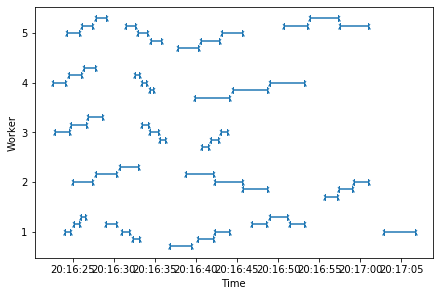

In [5]:
%matplotlib inline
_, ax = vis.subplots('Two runs of Auto-PyTorch with 20 budgets and 2 iterations')
ax = vis.job_timeline(df.Worker, df.StartTime, df.EndTime, ax=ax)

### One run of hyperopt with 300 max eval

In [10]:
total = pd.DataFrame()
for node in range(1, 5):
    df = pd.read_csv(f'log/2019-09-30T10:04:29/hyper{node}.csv', sep='\t',
                     names=['StartTime', 'EndTime', 'Node'])
    total = total.append(df)
total = total.reset_index(drop=True)
total['Node'] = pd.to_numeric(total.Node)
total['StartTime'] = pd.to_datetime(total.StartTime)
total['EndTime'] = pd.to_datetime(total.EndTime)
total = total.reset_index(drop=True)

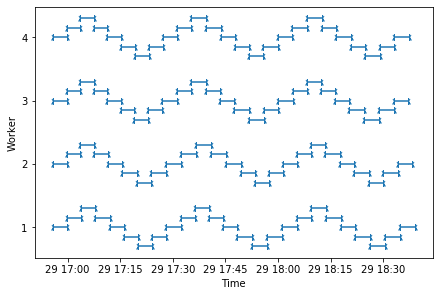

In [11]:
%matplotlib inline
_, ax = vis.subplots('One run of hyperopt with 300 max eval')
ax = vis.job_timeline(total.Node, total.StartTime, total.EndTime, ax=ax)

In [12]:
ax.figure.savefig('/tmp/workspace/2iterautopy.png', dpi=900)

### One run of Auto-PyTorch with 200 budget and 10 iterations.

#### The timeline
It seems that the algorithm can finish earlier than max iterations

In [30]:
total = pd.DataFrame()
for node in range(1, 6):
    df = pd.read_csv(f'log/2019-09-30T10:04:29/node{node}.csv', sep='\t',
                     names=['Iter', 'Unknown', 'JobId', 'StartTime', 'EndTime'])
    df['Node'] = node
    total = total.append(df)
total['StartTime'] = pd.to_datetime(total.StartTime)
total['EndTime'] = pd.to_datetime(total.EndTime)
total = total.reset_index(drop=True)

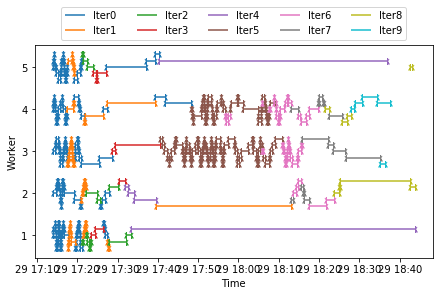

In [31]:
%matplotlib inline
_, ax = vis.subplots('One run of Auto-PyTorch with 200 budget and 10 iterations')
vis.job_timeline(total.Node, total.StartTime, total.EndTime, groupby=total.Iter, label='Iter{key}', ax=ax)
vis.legend(ax, ncol=5)

#### The job duration distribution of the same run

In [32]:
total['Duration'] = total.EndTime - total.StartTime
total['Duration'] = total.Duration.astype('timedelta64[s]')

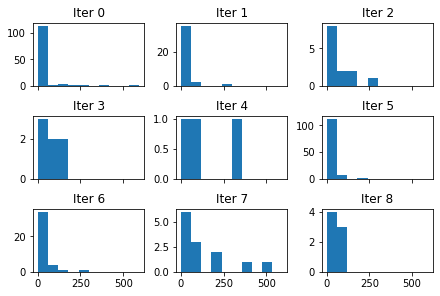

In [33]:
%matplotlib inline
_, axs = vis.subplots('Job duration distribution of the same run', nrows=3, ncols=3, sharex=True)
grouped = total.groupby('Iter')
bins = None
for ax, (it, grp) in zip(axs.flat, total.groupby('Iter')):
    _, bins, _ = ax.hist(grp.Duration, bins=bins)
    ax.set_title(f'Iter {it}')

### 10 workers and two iterations

#### The timeline

In [17]:
total = pd.DataFrame()
for node in range(1, 10):
    df = pd.read_csv(f'log/2019-10-07T11:29:19/worker{node}.log', sep='\t',
                     names=['StartTime', 'EndTime', 'Iter', 'JobId', 'Budget', 'Epoches'])
    df['Node'] = node
    total = total.append(df)
total['StartTime'] = pd.to_datetime(total.StartTime)
total['EndTime'] = pd.to_datetime(total.EndTime)
for col in ['Budget', 'Iter', 'JobId', 'Epoches']:
    total[col] = pd.to_numeric(total[col])
total = total.reset_index(drop=True)

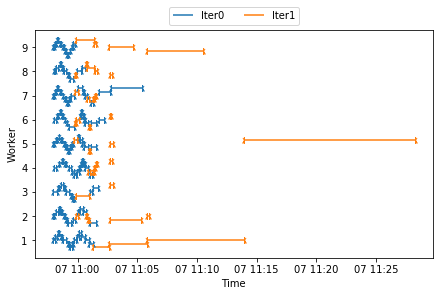

In [18]:
%matplotlib inline
_, ax = vis.subplots('One run of Auto-PyTorch with 20 budget and 2 iterations with 10 workers')
vis.job_timeline(total.Node, total.StartTime, total.EndTime, groupby=total.Iter, label='Iter{key}', ax=ax)
vis.legend(ax, ncol=2)

#### \# of jobs and speed distribution

In [36]:
total['Duration'] = total.EndTime - total.StartTime
total['Duration'] = total.Duration.astype('timedelta64[s]')

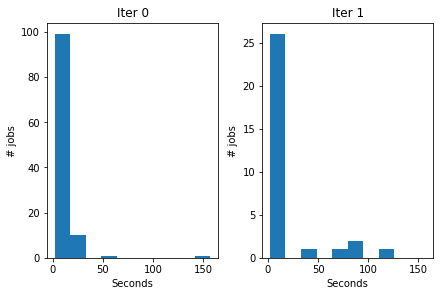

In [37]:
%matplotlib inline
_, axs = vis.subplots('Job duration distribution of the same run', nrows=1, ncols=2, sharex=True)
grouped = total.groupby('Iter')
bins = None
for ax, (it, grp) in zip(axs.flat, total.groupby('Iter')):
    _, bins, _ = ax.hist(grp.Duration, bins=bins)
    ax.set_title(f'Iter {it}')
    ax.set_xlabel('Seconds')
    ax.set_ylabel('# jobs')

Text(0, 0.5, 'Second/Epoch')

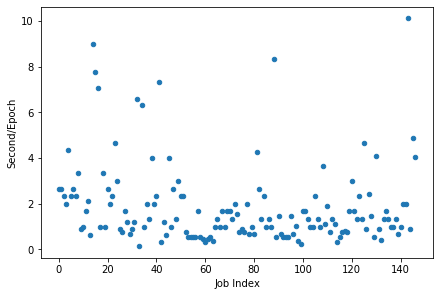

In [38]:
speed = total.Duration / total.Epoches
_, ax = vis.subplots('Job speed')
speed.reset_index().plot(x='index', y=0, ax=ax, kind='scatter')
ax.set_xlabel('Job Index')
ax.set_ylabel('Second/Epoch')

### One run with 20 budget and 5 iterations with 10 workers

In [19]:
total = load_jobs('tentacled-seal')

Loading log/tentacled-seal/jobs.csv


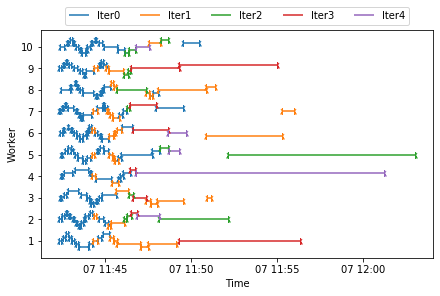

In [20]:
%matplotlib inline
_, ax = vis.subplots('One run of Auto-PyTorch with 20 budget and 5 iterations with 10 workers')
vis.job_timeline(total.Node, total.StartTime, total.EndTime, groupby=total.Iter, label='Iter{key}', ax=ax)
vis.legend(ax, ncol=5)

### One run with 100 budget and 5 iterations with 7 workers

In [3]:
total = load_jobs('pygmy', '7')

Loading log/pygmy-tapir/multiworker-num_worker-7-jobs.csv


In [4]:
_, ax = vis.subplots('One run of Auto-PyTorch with 100 budget and 5 iterations with 7 workers')
vis.job_timeline(total.Node, total.StartTime, total.EndTime, groupby=total.Iter, label='Iter{key}', ax=ax)
vis.legend(ax, ncol=5)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### 100 budget and diff \# of workers

Loading log/wild-fulmar/multiworker-num_worker-1-jobs.csv
Loading log/wild-fulmar/multiworker-num_worker-2-jobs.csv
Loading log/wild-fulmar/multiworker-num_worker-3-iter-15-jobs.csv
Loading log/wild-fulmar/multiworker-num_worker-4-jobs.csv
Loading log/wild-fulmar/multiworker-num_worker-6-iter-5-jobs.csv
Loading log/wild-fulmar/multiworker-num_worker-6-iter-15-jobs.csv
Loading log/wild-fulmar/multiworker-num_worker-8-jobs.csv
Loading log/wild-fulmar/multiworker-num_worker-10-jobs.csv


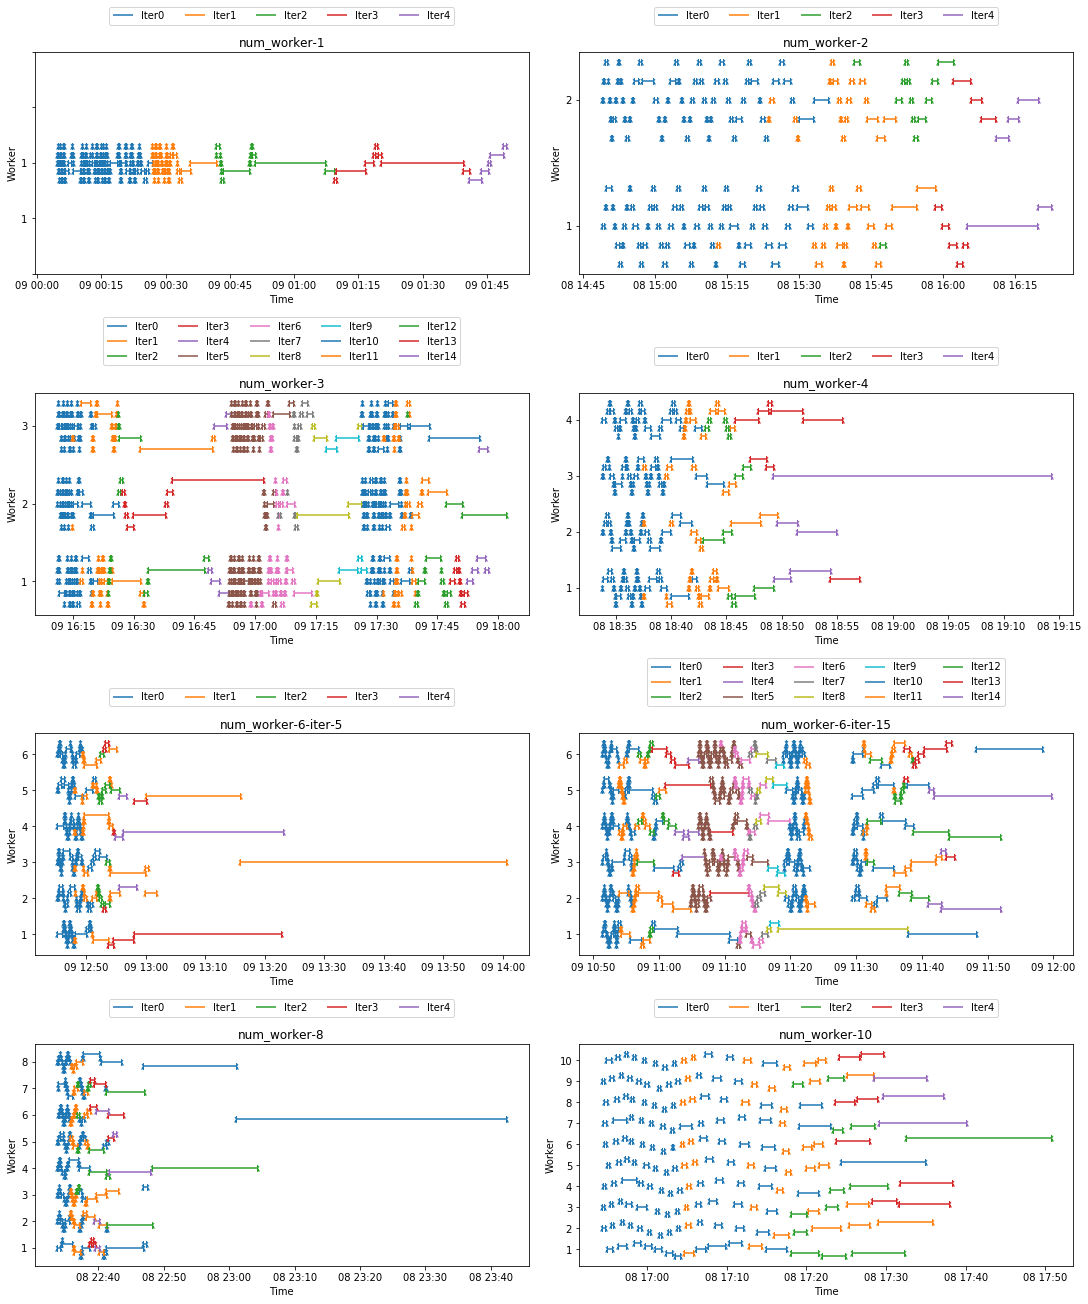

In [13]:
%matplotlib inline
ylims = {
    'num_worker-1': [-2, 2]
}
tags = [
    'num_worker-1',
    'num_worker-2',
    'num_worker-3',
    'num_worker-4',
    'num_worker-6-iter-5',
    'num_worker-6-iter-15',
    'num_worker-8',
    'num_worker-10',
]
_, axs = vis.subplots(f'Auto-PyTorch with 100 budget and diff num of workers', ncols=2, nrows=4, figsize=(15, 18))

for tag, ax in zip(tags, axs.flatten()):
    total = load_jobs('wild-fulmar', tag)
    vis.job_timeline(total.Node, total.StartTime, total.EndTime, groupby=total.Iter, label='Iter{key}', ax=ax)
    vis.legend(ax, ncol=5, bbox_to_anchor=(0.5, 1.1))
    ax.set_title(tag)
    ylim = ylims.get(tag, None)
    if ylim:
        ax.set_ylim(ylim)

In [5]:
ylims = {
    'num_worker-1': [-2, 2]
}
tags = [
    'num_worker-1',
    'num_worker-2',
    'num_worker-3',
    'num_worker-4',
    'num_worker-6-iter-5',
    'num_worker-6-iter-15',
    'num_worker-8',
    'num_worker-10',
]
_, axs = vis.subplots(f'Auto-PyTorch with 200 budget and diff num of workers', ncols=2, nrows=4, figsize=(None, 18))

for tag, ax in zip(tags, axs.flatten()):
    total = load_jobs('wild-fulmar', tag)
    vis.job_timeline(total.Node, total.StartTime, total.EndTime, groupby=total.Iter, label='Iter{key}', ax=ax)
    vis.legend(ax, ncol=5, bbox_to_anchor=(0.5, 1.1))
    
    tot_duration = total.EndTime.max() - total.StartTime.min()
    ax.set_title(f'{tag}: JCT: {tot_duration}')
    ylim = ylims.get(tag, None)
    if ylim:
        ax.set_ylim(ylim)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Loading log/wild-fulmar/multiworker-num_worker-1-jobs.csv
Loading log/wild-fulmar/multiworker-num_worker-2-jobs.csv
Loading log/wild-fulmar/multiworker-num_worker-3-iter-15-jobs.csv
Loading log/wild-fulmar/multiworker-num_worker-4-jobs.csv
Loading log/wild-fulmar/multiworker-num_worker-6-iter-5-jobs.csv
Loading log/wild-fulmar/multiworker-num_worker-6-iter-15-jobs.csv
Loading log/wild-fulmar/multiworker-num_worker-8-jobs.csv
Loading log/wild-fulmar/multiworker-num_worker-10-jobs.csv


### Repeat 1 worker and 3 workers exp with 200 budget

In [46]:
tags = [
    'num_worker-1-iter-5-name-a',
    'num_worker-3-iter-5-name-a',
    'num_worker-1-iter-5-name-b',
    'num_worker-3-iter-5-name-b',
    'num_worker-1-iter-5-name-c',
    'num_worker-3-iter-5-name-c',
    'time_budget-num_worker-1-iter-5-name-a',
    'time_budget-num_worker-3-iter-5-name-a',
]
_, axs = vis.subplots(f'Auto-PyTorch with 200 budget repeat exp', ncols=2, nrows=4, figsize=(None, 18), sharey=True)

for tag, ax in zip(tags, axs.flatten()):
    total = load_jobs('imaginary-impala', tag)
    vis.job_timeline(total.Node, total.StartTime, total.EndTime, groupby=total.Iter, label='Iter{key}', ax=ax)
    vis.legend(ax, ncol=5, bbox_to_anchor=(0.5, 1.1))
    
    tot_duration = total.EndTime.max() - total.StartTime.min()
    ax.set_title(f'{tag} JCT: {tot_duration}')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Loading log/imaginary-impala/num_worker-1-iter-5-name-a-jobs.csv
Loading log/imaginary-impala/num_worker-3-iter-5-name-a-jobs.csv
Loading log/imaginary-impala/num_worker-1-iter-5-name-b-jobs.csv
Loading log/imaginary-impala/num_worker-3-iter-5-name-b-jobs.csv
Loading log/imaginary-impala/num_worker-1-iter-5-name-c-jobs.csv
Loading log/imaginary-impala/num_worker-3-iter-5-name-c-jobs.csv
Loading log/imaginary-impala/time_budget-num_worker-1-iter-5-name-a-jobs.csv
Loading log/imaginary-impala/time_budget-num_worker-3-iter-5-name-a-jobs.csv


# Auto-PyTorch with Distributed Training

In [26]:
def parse_new_log(slug, tag):
    log_dir = fuzzy_slug(slug)
    
    # find file
    jl_file = log_dir / f'{tag}.jsonl'
    if not jl_file.is_file():
        # try glob
        for jl_file in log_dir.glob(f'*{tag}*.jsonl'):
            if jl_file.is_file():
                break
            raise ValueError(f'JSONL file {jl_file} does not exist')
    
    # load it
    print(f'Loading {jl_file}')
    df = pd.read_json(jl_file, lines=True)
    
    # correct some data
    df['job.id'] = df.job.apply(lambda obj: f"({', '.join(str(el) for el in obj['id'])})")
    return df

## 3 workers, 2 workers per job

In [35]:
total = load_jobs('met', 'num_worker-3')
_, ax = vis.subplots(f'Auto-PyTorch with 3 workers, 2 workers per job')
vis.job_timeline(total.Node, total.StartTime, total.EndTime, groupby=total.Iter, label='Iter{key}', ax=ax)
vis.legend(ax, bbox_to_anchor=(0.5, 1.1))
print(total.EndTime.max() - total.StartTime.min())

Loading log/meticulous-impala/num_worker-3-iter-2-name-a-jobs.csv


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

0 days 00:16:52.488000


## 3 workers, baseline

In [36]:
total = load_jobs('met', 'name-baseline')
_, ax = vis.subplots(f'Auto-PyTorch with 3 workers, baseline')
vis.job_timeline(total.Node, total.StartTime, total.EndTime, groupby=total.Iter, label='Iter{key}', ax=ax)
vis.legend(ax, ncol=2, bbox_to_anchor=(0.5, 1.1))
print(total.EndTime.max() - total.StartTime.min())

Loading log/meticulous-impala/num_worker-3-iter-2-name-baseline-jobs.csv


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

0 days 00:09:15.285000


## 4 workers, 2 workers per job

In [42]:
total = load_jobs('awesome', 'num_worker-4')
total = total[total.Iter <= 1]
_, ax = vis.subplots(f'Auto-PyTorch with 4 workers, 2 workers per job')
vis.job_timeline(total.Node, total.StartTime, total.EndTime, groupby=total.Iter, label='Iter{key}', ax=ax)
vis.legend(ax, ncol=5, bbox_to_anchor=(0.5, 1.1))
print(total.EndTime.max() - total.StartTime.min())

Loading log/awesome-fennec/num_worker-4-iter-5-name-a-jobs.csv


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

0 days 00:45:19.523000


## 2 workers, baseline, sync iter

In [4]:
total = load_jobs('maize', 'name-cc')
_, ax = vis.subplots(f'Auto-PyTorch with sync iter')
vis.job_timeline(total.Node, total.StartTime, total.EndTime, groupby=total.Iter, label='Iter{key}', ax=ax)
vis.legend(ax, ncol=5, bbox_to_anchor=(0.5, 1.1))
print(total.EndTime.max() - total.StartTime.min())

Loading log/maize-elephant/num_worker-2-iter-5-name-cc-jobs.csv


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

0 days 02:43:14.443000


## 2 workers, sync iter, RungBased sched

In [7]:
total = load_jobs('viva', 'name-RungBased2')
_, ax = vis.subplots(f'Auto-PyTorch with sync iter')
vis.job_timeline(total.Node, total.StartTime, total.EndTime, groupby=total.Iter, label='Iter{key}', ax=ax)
vis.legend(ax, ncol=5, bbox_to_anchor=(0.5, 1.1))
print(total.EndTime.max() - total.StartTime.min())

Loading log/vivacious-harrier/num_worker-2-iter-1-name-RungBased2-jobs.csv


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

0 days 00:19:30.147000


## 3 workers, 3 iters

`funny-tamarin`

In [76]:
total = load_jobs('funny-tamarin', 'name-job5').sort_values(by=['Iter', 'Rung', 'JobId'])
_, ax = vis.subplots(f'Auto-PyTorch with sync iter')
vis.job_timeline(total.Node, total.StartTime, total.EndTime, groupby=[total.Iter,total.Rung],
                 label='Iter {key[0]} Rung{key[1]}', ax=ax)
vis.legend(ax, ncol=5, bbox_to_anchor=(0.5, 1.1))
print(total.EndTime.max() - total.StartTime.min())

Loading log/funny-tamarin/num_worker-3-iter-3-name-job5-jobs.csv


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

0 days 01:09:25.183000


In [4]:
total = total.sort_values(by=['Iter', 'Rung', 'JobId'])

In [ ]:
total